In [33]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from ISLP import load_data,confusion_table
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.pyplot import subplots
from statsmodels.stats.anova import anova_lm
from ISLP.models import bs, ns
from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import sklearn.model_selection as skm
from sklearn.model_selection import cross_val_score


# Lab 8 
Bruce Cai

Using the OJ data set - which is part of the ISLP package:

a. Create a training set containing a random sample of 800 obser- vations, and a test
set containing the remaining observations.

In [8]:
data = load_data("OJ")

print(data.head(5))
train_set, test_set = train_test_split(data, train_size=800, random_state=42)
print(len(train_set))

  Purchase  WeekofPurchase  StoreID  PriceCH  PriceMM  DiscCH  DiscMM  \
0       CH             237        1     1.75     1.99    0.00     0.0   
1       CH             239        1     1.75     1.99    0.00     0.3   
2       CH             245        1     1.86     2.09    0.17     0.0   
3       MM             227        1     1.69     1.69    0.00     0.0   
4       CH             228        7     1.69     1.69    0.00     0.0   

   SpecialCH  SpecialMM   LoyalCH  SalePriceMM  SalePriceCH  PriceDiff Store7  \
0          0          0  0.500000         1.99         1.75       0.24     No   
1          0          1  0.600000         1.69         1.75      -0.06     No   
2          0          0  0.680000         2.09         1.69       0.40     No   
3          0          0  0.400000         1.69         1.69       0.00     No   
4          0          0  0.956535         1.69         1.69       0.00    Yes   

   PctDiscMM  PctDiscCH  ListPriceDiff  STORE  
0   0.000000   0.000000   

b. Fit a tree to the training data, with Purchase as the response and the other
variables as predictors. What is the training error rate?

In [25]:
Y = train_set['Purchase']
model = MS(train_set.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(train_set)
feature_names = list(D.columns)
X = np.asarray(D)
clf = DTC(criterion='entropy',
          max_depth=3,
          random_state=42)        
clf.fit(X, Y)
print("The training error rate is: ",1-accuracy_score(Y, clf.predict(X)))


The training error rate is:  0.15249999999999997


c. Create a plot of the tree, and interpret the results. How many terminal nodes does
the tree have?

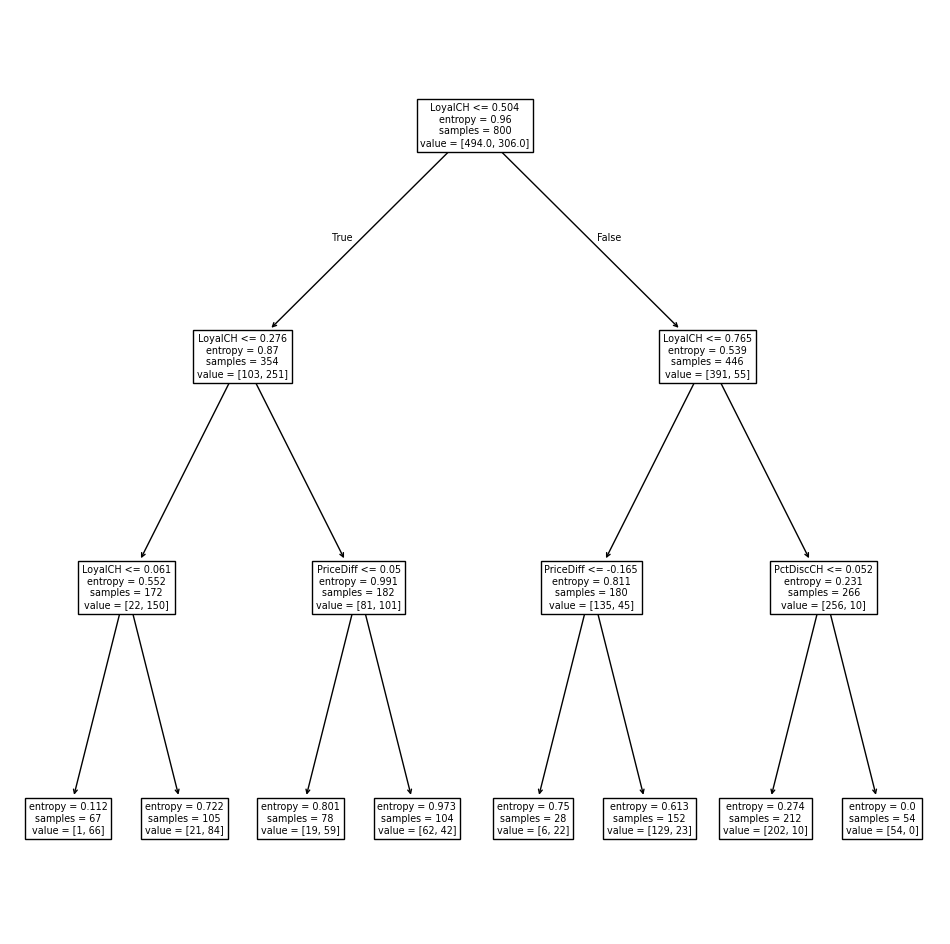

In [17]:
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

There are 8 terminal nodes in this tree. And we can know that "LoyalCH" is the most important variable in this model.

d. Use the export_tree() function to produce a text summary of the fitted tree. Pick
one of the terminal nodes, and interpret the information displayed.

In [18]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- weights: [1.00, 66.00] class: MM
|   |   |--- LoyalCH >  0.06
|   |   |   |--- weights: [21.00, 84.00] class: MM
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- weights: [19.00, 59.00] class: MM
|   |   |--- PriceDiff >  0.05
|   |   |   |--- weights: [62.00, 42.00] class: CH
|--- LoyalCH >  0.50
|   |--- LoyalCH <= 0.76
|   |   |--- PriceDiff <= -0.16
|   |   |   |--- weights: [6.00, 22.00] class: MM
|   |   |--- PriceDiff >  -0.16
|   |   |   |--- weights: [129.00, 23.00] class: CH
|   |--- LoyalCH >  0.76
|   |   |--- PctDiscCH <= 0.05
|   |   |   |--- weights: [202.00, 10.00] class: CH
|   |   |--- PctDiscCH >  0.05
|   |   |   |--- weights: [54.00, 0.00] class: CH



|--- LoyalCH >  0.76

|   |--- PctDiscCH <= 0.05

|   |   |--- weights: [202.00, 10.00] class: CH

This node suggests that when customers have a high loyalty score toward Citrus Hill (LoyalCH > 0.76) and the discount on Citrus Hill is minimal (PctDiscCH <= 0.05), they are still highly likely to purchase CH over MM.

e. Predict the response on the test data, and produce a confusion matrix comparing
the test labels to the predicted test labels. What is the test error rate?

In [27]:
Y_test = test_set['Purchase']
model = MS(test_set.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(test_set)
feature_names = list(D.columns)
X_test = np.asarray(D)
# Predict the response on the test data

conf_matrix = confusion_table( clf.predict(X_test),Y_test)
print("Confusion Matrix:\n", conf_matrix)

# Calculate the test error rate
test_accuracy = accuracy_score(Y_test, clf.predict(X_test))
test_error_rate = 1 - test_accuracy
print("Test error rate: ", test_error_rate)

Confusion Matrix:
 Truth       CH  MM
Predicted         
CH         145  39
MM          14  72
Test error rate:  0.1962962962962963


f. Use cross-validation on the training set in order to determine the optimal tree
size.

In [28]:
clf = DTC(criterion='entropy', random_state=42)
clf.fit(X, Y)
accuracy_score(Y_test, clf.predict(X_test))

0.7592592592592593

In [30]:
ccp_path = clf.cost_complexity_pruning_path(X, Y)
kfold = skm.KFold(10,
                  random_state=42,
                  shuffle=True)
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X, Y)
grid.best_score_

0.8225

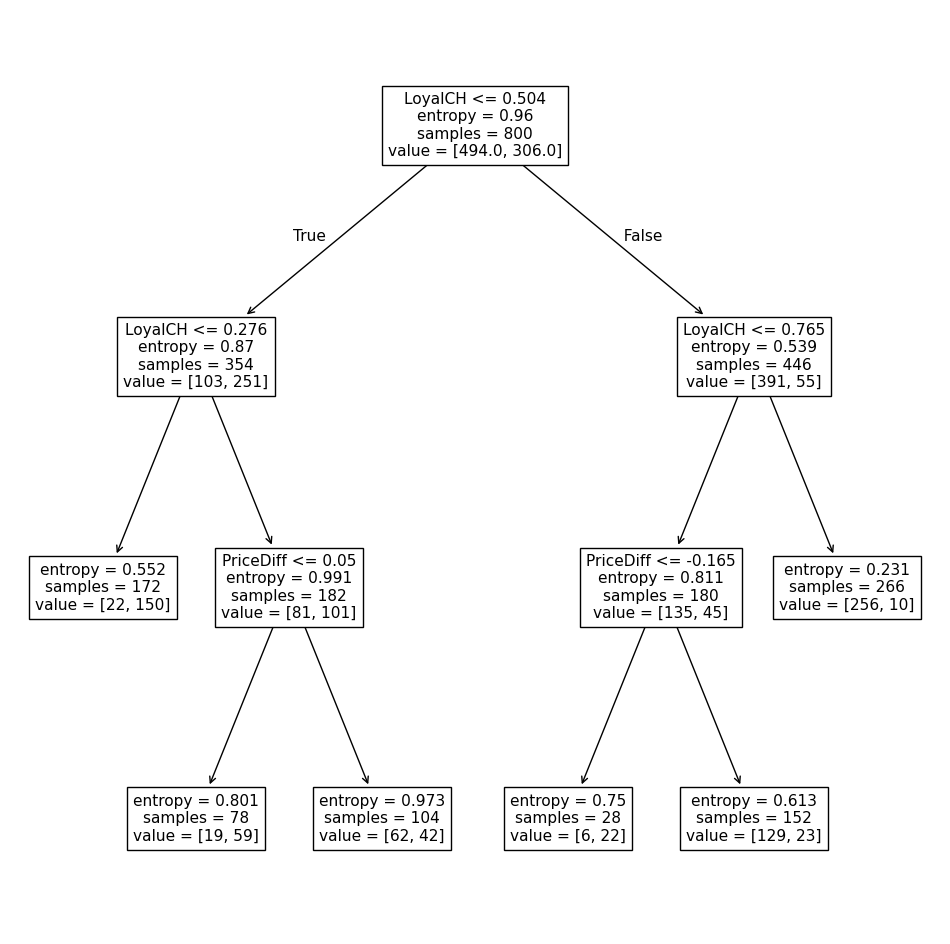

In [31]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);

g. Produce a plot with tree size on the x-axis and cross-validated classification error
rate on the y-axis.

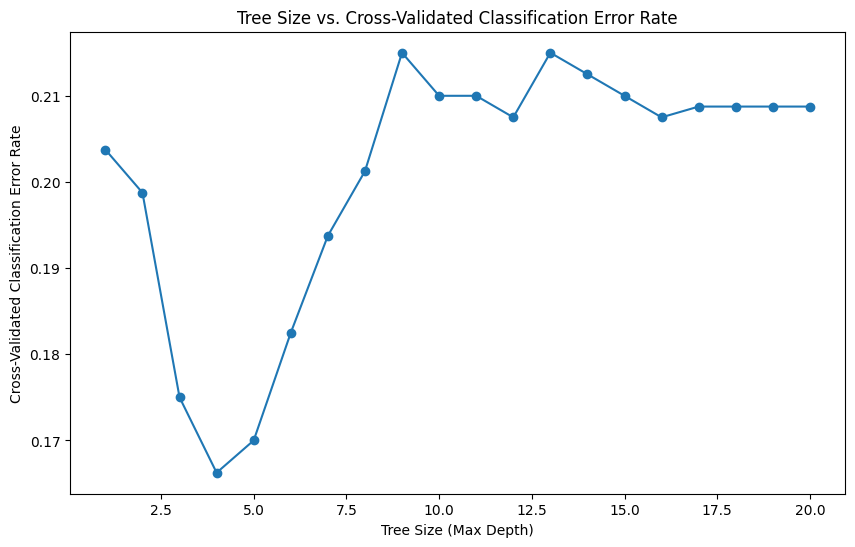

In [34]:
depths = range(1, 21)  
error_rates = []

for depth in depths:
    tree_model = DTC(max_depth=depth, random_state=42)
    scores = cross_val_score(tree_model, X, Y, cv=5, scoring='accuracy')
    error_rate = 1 - np.mean(scores)
    error_rates.append(error_rate)

    
plt.figure(figsize=(10, 6))
plt.plot(depths, error_rates, marker='o')
plt.xlabel("Tree Size (Max Depth)")
plt.ylabel("Cross-Validated Classification Error Rate")
plt.title("Tree Size vs. Cross-Validated Classification Error Rate")
plt.show()

h. Which tree size corresponds to the lowest cross-validated classi- fication error
rate?

In [37]:
min_error_rate = min(error_rates)
optimal_depth = depths[error_rates.index(min_error_rate)]
print('The tree with maxium depth of:',optimal_depth,"has the lowest cross-validated classification error rate")

The tree with maxium depth of: 4 has the lowest cross-validated classification error rate


i. Produce a pruned tree corresponding to the optimal tree size obtained using
cross-validation. If cross-validation does not lead to selection of a pruned tree,
then create a pruned tree with five terminal nodes.

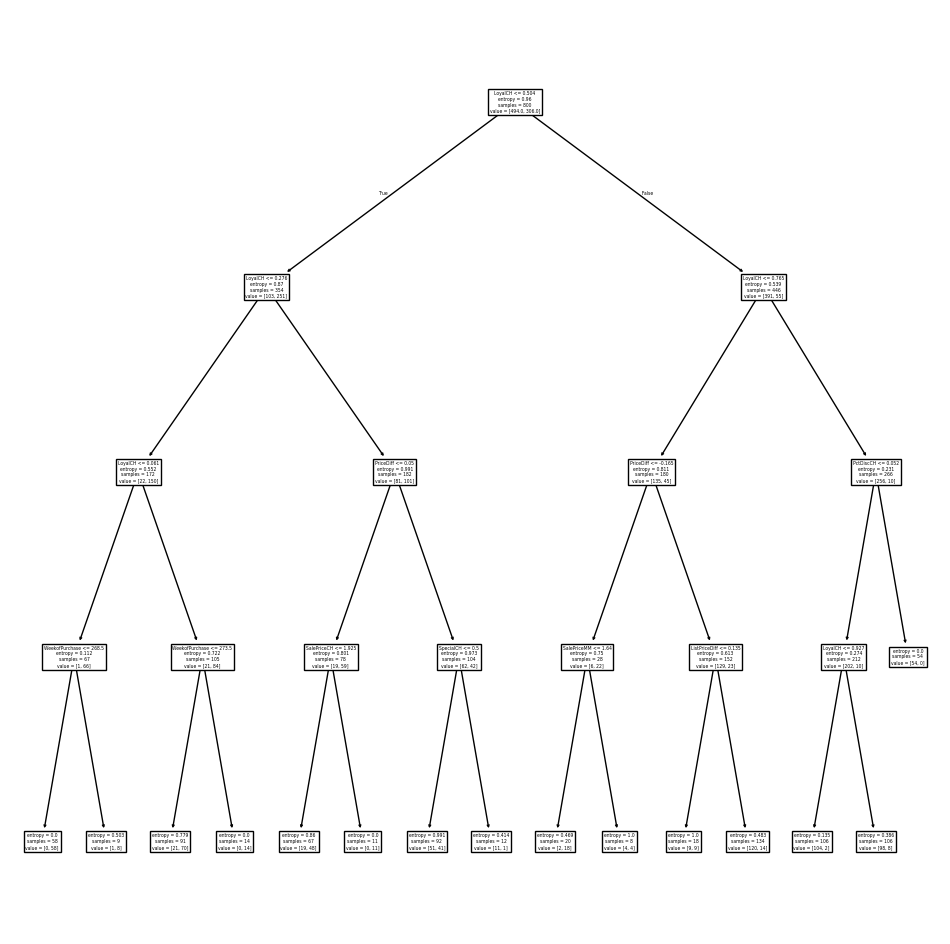

In [39]:
clf = DTC(criterion='entropy',
          max_depth=optimal_depth,
          random_state=42)        
clf.fit(X, Y)
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);

j. Compare the training error rates between the pruned and un- pruned trees. Which
is higher?

In [41]:
unpruned_tree = DTC(criterion='entropy', random_state=42)
unpruned_tree.fit(X, Y)
y_train_pred_unpruned = unpruned_tree.predict(X)
unpruned_train_error_rate = 1 - accuracy_score(Y, y_train_pred_unpruned)

# Train the pruned tree (with optimal depth or limited terminal nodes)
pruned_tree = DTC(criterion='entropy', max_depth=optimal_depth, random_state=42)
# Alternatively, use: DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=5, random_state=42)
pruned_tree.fit(X, Y)
y_train_pred_pruned = pruned_tree.predict(X)
pruned_train_error_rate = 1 - accuracy_score(Y, y_train_pred_pruned)
print(f"Training Error Rate (Unpruned Tree): {unpruned_train_error_rate:.4f}")
print(f"Training Error Rate (Pruned Tree): {pruned_train_error_rate:.4f}")

Training Error Rate (Unpruned Tree): 0.0075
Training Error Rate (Pruned Tree): 0.1525


The training error rate for pruned trees is higher.

k. Compare the test error rates between the pruned and unpruned trees. Which is
higher?

In [42]:
y_test_pred_unpruned = unpruned_tree.predict(X_test)
unpruned_test_error_rate = 1 - accuracy_score(Y_test, y_test_pred_unpruned)

# Predict on the test set using the pruned tree
y_test_pred_pruned = pruned_tree.predict(X_test)
pruned_test_error_rate = 1 - accuracy_score(Y_test, y_test_pred_pruned)

# Display the results
print(f"Test Error Rate (Unpruned Tree): {unpruned_test_error_rate:.4f}")
print(f"Test Error Rate (Pruned Tree): {pruned_test_error_rate:.4f}")

Test Error Rate (Unpruned Tree): 0.2704
Test Error Rate (Pruned Tree): 0.1889


The test error for unpruned tree is higher. This implied pruned tree reduced overfitting of unpruned and performed better on the test set.